In [1]:
2

2

In [2]:
import sys
sys.path.append('..')
sys.path.append('../loaders')

In [3]:
from raft import RAFTExhaustiveDataset
from config import config_parser
import util

/export/home/mandreev/anaconda3/envs/omnimotion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import util
import imageio
import os
import json
import cv2
from PIL import Image

import numpy as np
from PIL import Image

def tile_videos(video_arr):
    # Helper function to detect if an image is a numpy array
    def is_numpy(img):
        return isinstance(img, np.ndarray)
    
    # Convert numpy to PIL
    def numpy_to_pil(np_img):
        return Image.fromarray(np_img)
    
    # Convert PIL to numpy
    def pil_to_numpy(pil_img):
        return np.array(pil_img)
    
    # Get image dimensions regardless of type
    def get_dimensions(img):
        if is_numpy(img):
            return img.shape[1], img.shape[0]
        return img.width, img.height
    
    # Helper function to get the maximum height and total width of two images
    def get_combined_dimensions(img1, img2):
        width1, height1 = get_dimensions(img1)
        width2, height2 = get_dimensions(img2)
        return width1 + width2, max(height1, height2)
    
    tiled_video = []

    # Process each frame time-wise
    max_length = max(len(video) for video_pair in video_arr for video in video_pair if video is not None)
    for frame_index in range(max_length):
        frames_to_merge = []

        for video_pair in video_arr:
            combined_frame = None

            # Fetch the frame if it exists, else use a black frame
            frame1 = video_pair[0][frame_index] if (video_pair[0] is not None and frame_index < len(video_pair[0])) else Image.new('RGB', (640, 480), color='black')
            frame2 = video_pair[1][frame_index] if (video_pair[1] is not None and frame_index < len(video_pair[1])) else Image.new('RGB', (640, 480), color='black')

            # Convert numpy frames to PIL for easier handling
            if is_numpy(frame1):
                frame1 = numpy_to_pil(frame1)
            if is_numpy(frame2):
                frame2 = numpy_to_pil(frame2)

            # Merge the two frames side by side
            width, height = get_combined_dimensions(frame1, frame2)
            combined_frame = Image.new('RGB', (width, height))
            combined_frame.paste(frame1, (0, 0))
            combined_frame.paste(frame2, (frame1.width, 0))

            frames_to_merge.append(combined_frame)

        # Now merge frames vertically
        total_width = frames_to_merge[0].width
        total_height = sum(frame.height for frame in frames_to_merge)
        final_frame = Image.new('RGB', (total_width, total_height))
        y_offset = 0
        for frame in frames_to_merge:
            final_frame.paste(frame, (0, y_offset))
            y_offset += frame.height

        tiled_video.append(final_frame)

    return tiled_video

# Example usage remains the same



def save_video(frames, out_path):
    """
        Args:
            frames: list of np.ndarray of shape (H, W, 3) and dtype np.uint8
    """
    try:
        imageio.mimwrite(out_path, frames, quality=8, fps=10)

        print(f'💾 Saved video to {out_path}')
    except Exception as e:
        print(f'💾⚠️ Failed to save video to {out_path}')
        print(e)
        print(f'frames[0].shape: {frames[0].shape}, frames[0].dtype: {frames[0].dtype}')

def flow_to_video(flows):
    return [util.flow_to_image(flow_map) for flow_map in tqdm(flows, "converting flows to images")]

def save_flow_as_video(out_path, flows):
    flow_imgs = flow_to_video(flows)

    save_video(flow_imgs, out_path)

    return flow_imgs

def count_map_to_image(count_maps, i):

    # expand pixel value into 3 dimensions
    count_map = np.repeat(count_maps[i][:, :, np.newaxis], 3, axis=2)

    # normalize across all count maps
    count_map = count_map / np.max(count_maps)
    
    # convert to np.uint8
    count_map = (count_map * 255).astype(np.uint8)

    return count_map

def draw_text(frames, text, location):
    """ Returns array of frames with text drawn on them """
    for i in range(len(frames)):
        frames[i] = cv2.putText(frames[i], text, location, cv2.FONT_HERSHEY_SIMPLEX, 1, (220, 20, 200), 2, cv2.LINE_AA)
    return frames
def concat_frames(frames1, frames2, left_label=None, right_label=None):
    """ Returns array of side-by-side frames of shape (N, H, W*2, 3) """
    concatted = np.concatenate([frames1, frames2], axis=2)

    if left_label is not None:
        concatted = draw_text(concatted, left_label, (10, 50))

    if right_label is not None:
        concatted = draw_text(concatted, right_label, (concatted.shape[2]//2 + 10, 50))
    
    return concatted


def save_json(out_path, data):
    """ Saves data to json file """
    with open(out_path, 'w') as f:
        json.dump(data, f)
    print(f'💾 Saved json to {out_path}')

def pad_frames(frames, head_frames=0, tail_frames=0):
    """
        Pad the video with head_frames and tail_frames of black frames.
        Args:
            frames (`PIL.Image`): list of frames
    """
    if head_frames > 0:
        frames = [Image.new('RGB', (640, 480), color='black') for _ in range(head_frames)] + frames
    if tail_frames > 0:
        frames = frames + [Image.new('RGB', (640, 480), color='black') for _ in range(tail_frames)]
    return frames
    

In [10]:
import numpy as np
import imageio
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

import matplotlib.pyplot as plt

class PreprocessingInspector():
    def __init__(self, seq_name, data_dir):
        self.seq_name = seq_name
        self.data_dir = data_dir

        self.flow_dir = os.path.join(DATA_DIR, 'raft_exhaustive')
        self.flow_mask_dir = os.path.join(DATA_DIR, 'raft_masks')
        self.img_dir = os.path.join(DATA_DIR, 'color')
        self.img_names = sorted(os.listdir(self.img_dir))
    

    def visualize_count_maps(self, out_dir=None):
        if out_dir is None:
            out_dir = os.path.join(self.seq_name, 'count_maps')
        
        count_dir = os.path.join(DATA_DIR, 'count_maps')
        count_img_names = sorted(os.listdir(count_dir))

        count_maps = [imageio.imread(os.path.join(count_dir, img_name)) for img_name in tqdm(count_img_names, desc="Loading count maps")]
        count_images = [count_map_to_image(count_maps, i) for i in tqdm(range(len(count_maps)), desc="Converting count maps to images")]

        os.makedirs(out_dir, exist_ok=True)
        save_video(count_images, os.path.join(out_dir, 'count_maps.mp4'))
    
    
    def _load_flow_maps(self, frame_interval, load_masks=True, load_flows=True):
        flows_raw = []
        flows_masks = []

        def process_frame(i):
            img_name1 = self.img_names[i]
            img_name2 = self.img_names[i + frame_interval]
            flow, mask = None, None

            if load_flows:
                flow_file = os.path.join(self.flow_dir, '{}_{}.npy'.format(img_name1, img_name2))
                flow = np.load(flow_file)

            if load_masks:
                mask_file = os.path.join(self.flow_mask_dir, '{}_{}.png'.format(img_name1, img_name2))
                masks = imageio.imread(mask_file) / 255.

                cycle_consistency_mask = masks[..., 0] > 0
                occlusion_mask = masks[..., 1] > 0
                mask = cycle_consistency_mask | occlusion_mask

                if mask.sum() == 0:
                    mask = np.ones_like(cycle_consistency_mask)

            return flow, mask

        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(process_frame, i) for i in range(0, len(self.img_names) - frame_interval)]
            for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc='Loading flow maps'):
                flow, mask = future.result()
                if load_flows: flows_raw.append(flow)
                if load_masks: flows_masks.append(mask)

        return flows_raw, flows_masks


    def _load_frames(self):
        frames = [None] * len(self.img_names)  # Initialize with None to maintain order
        
        def load_frame(i):
            img_name1 = self.img_names[i]
            img1 = imageio.imread(os.path.join(self.img_dir, img_name1))
            return i, img1  # Return index and frame to maintain order

        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(load_frame, i) for i in range(len(self.img_names))]
            for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc='Loading frames'):
                i, frame = future.result()
                frames[i] = frame  # Place frames in the correct order

        return frames


    def visualize_raft_flows(self, out_dir=None, frame_intervals=[1]):
        output_video_grid = [
            [self._load_frames(), None, None]
        ]

        padded

        for frame_interval in frame_intervals:
            flows_raw, flows_masks = self._load_flow_maps(frame_interval)
            if out_dir is None:
                out_dir = os.path.join(self.seq_name, 'flows')

            stats = {
                'kept_correspondences': int(sum([mask.sum() for mask in flows_masks])),
                'total_correspondences': int(sum([mask.shape[0] * mask.shape[1] for mask in flows_masks])),
            }
            stats['percentage_kept'] = stats['kept_correspondences'] / stats['total_correspondences']
            print(stats)
            save_json(os.path.join(out_dir, f'stats_frame_interval={frame_interval}.json'), stats)
            
            print(f"Across the entire video, kept {stats['kept_correspondences']} out of {stats['total_correspondences']} pixel-to-pixel correspondences ({stats['percentage_kept'] * 100}%)")
            flows_filtered = [flow * mask[..., np.newaxis] for flow, mask in zip(flows_raw, flows_masks)]
            os.makedirs(out_dir, exist_ok=True)
            flows_raw_img = flow_to_video(flows_raw)
            flows_filtered_img = flow_to_video(flows_filtered)

            flows_raw_img = draw_text(flows_raw_img, f'Frame Interval = {frame_interval}, unfiltered', (10, 50))
            flows_filtered_img = draw_text(flows_filtered_img, f'Frame Interval = {frame_interval}, filtered', (10, 50))

            

            # flows_side_by_side = concat_frames(np.array(flows_raw_img), np.array(flows_filtered_img), left_label='Unfiltered', right_label='Filtered')
            # save_video(flows_side_by_side, os.path.join(out_dir, f'flow_side_by_side_frame_interval={frame_interval}.mp4'))

            masks_imgs = [count_map_to_image(flows_masks, i) for i in range(len(flows_masks))]
            output_video_grid.append([flows_raw_img, flows_filtered_img, masks_imgs])

            
            # save_video(masks_imgs, os.path.join(out_dir, f'masks_frame_interval={frame_interval}.mp4'))
        
        tiled_video = tile_videos(output_video_grid)
        save_video(tiled_video, os.path.join(out_dir, f'flows.mp4'))

    def plot_filtering_percentage_across_frame_intervals(self, frame_intervals=[1, 2, 4, 8, 16, 32]):
        results = []
        for frame_interval in tqdm(frame_intervals, desc=f"Computing stats for {len(frame_intervals)} frame intervals"):
            _, flows_masks = self._load_flow_maps(frame_interval, True, False)
            stats = {
                'kept_correspondences': int(sum([mask.sum() for mask in flows_masks])),
                'total_correspondences': int(sum([mask.shape[0] * mask.shape[1] for mask in flows_masks])),
            }
            stats['percentage_kept'] = stats['kept_correspondences'] / stats['total_correspondences']

            results.append({
                'frame_interval': frame_interval,
                **stats
            })


        # Sorting results by frame_interval for plotting
        results.sort(key=lambda x: x['frame_interval'])

        # Extracting values for plotting
        x_values = [result['frame_interval'] for result in results]
        y_values = [result['percentage_kept'] for result in results]

        # Plotting the bar chart
        plt.bar(x_values, y_values, color='blue')
        plt.xlabel('Frame Intervals')
        plt.ylabel('Percentage Kept (%)')
        plt.title('Filtering Percentage across Frame Intervals')
        plt.xticks(x_values)  # This sets the tick marks on x-axis based on the frame intervals
        plt.grid(axis='y')

        # Displaying the chart
        plt.tight_layout()
        plt.show()
        
            



In [15]:
SEQ_NAME = "bmx_short"
DATA_DIR = os.path.join("../omnimotion_videos/", SEQ_NAME)

inspector = PreprocessingInspector(SEQ_NAME, DATA_DIR)

Computing stats for 6 frame intervals:   0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_4038728/2755504842.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks = imageio.imread(mask_file) / 255.
Computing stats for 6 frame intervals: 100%|██████████| 6/6 [00:16<00:00,  2.82s/it]


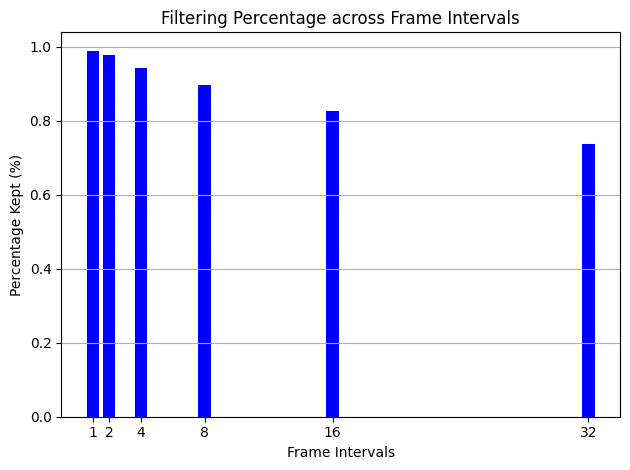

In [16]:
inspector.plot_filtering_percentage_across_frame_intervals()

In [17]:
inspector.visualize_raft_flows(frame_intervals=[1, 4, 12, 24])
inspector.visualize_count_maps()

Loading frames:   0%|          | 0/158 [00:00<?, ?it/s]/tmp/ipykernel_4038728/2755504842.py:73: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(os.path.join(self.img_dir, img_name1))
Loading flow maps:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_4038728/2755504842.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks = imageio.imread(mask_file) / 255.
Loading flow maps: 100%|██████████| 157/157 [00:04<00:00, 37.71it/s]


{'kept_correspondences': 47729569, 'total_correspondences': 48230400, 'percentage_kept': 0.9896158646828557}
💾 Saved json to bmx_short/flows/stats_frame_interval=1.json
Across the entire video, kept 47729569 out of 48230400 pixel-to-pixel correspondences (98.96158646828556%)


Loading flow maps: 100%|██████████| 154/154 [00:03<00:00, 38.74it/s]


{'kept_correspondences': 44541730, 'total_correspondences': 47308800, 'percentage_kept': 0.9415104589420996}
💾 Saved json to bmx_short/flows/stats_frame_interval=4.json
Across the entire video, kept 44541730 out of 47308800 pixel-to-pixel correspondences (94.15104589420996%)


Loading flow maps: 100%|██████████| 146/146 [00:05<00:00, 28.08it/s]


{'kept_correspondences': 38571274, 'total_correspondences': 44851200, 'percentage_kept': 0.8599830996718036}
💾 Saved json to bmx_short/flows/stats_frame_interval=12.json
Across the entire video, kept 38571274 out of 44851200 pixel-to-pixel correspondences (85.99830996718036%)


Loading flow maps: 100%|██████████| 134/134 [00:04<00:00, 33.19it/s]


{'kept_correspondences': 31800304, 'total_correspondences': 41164800, 'percentage_kept': 0.7725120491293532}
💾 Saved json to bmx_short/flows/stats_frame_interval=24.json
Across the entire video, kept 31800304 out of 41164800 pixel-to-pixel correspondences (77.25120491293532%)


converting flows to images: 100%|██████████| 134/134 [00:02<00:00, 55.57it/s]


💾 Saved video to bmx_short/flows/flows.mp4


Loading count maps:   0%|          | 0/158 [00:00<?, ?it/s]/tmp/ipykernel_4038728/2755504842.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  count_maps = [imageio.imread(os.path.join(count_dir, img_name)) for img_name in tqdm(count_img_names, desc="Loading count maps")]
Converting count maps to images: 100%|██████████| 158/158 [00:03<00:00, 43.37it/s]


💾 Saved video to bmx_short/count_maps/count_maps.mp4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_flow_as_arrows(flow_uv, stride=10):
    """
    Expects a two-dimensional flow image of shape.

    Args:
        flow_uv (np.ndarray): Flow UV image of shape [H,W,2]
        stride (int): The step size between arrows, for both height and width.

    Displays:
        A matplotlib figure with arrows representing the flow at each grid point.
    """
    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[-1] == 2, 'input flow must have shape [H,W,2]'
    
    H, W, _ = flow_uv.shape
    
    x = np.arange(0, W, stride)
    y = np.arange(0, H, stride)
    
    x, y = np.meshgrid(x, y)
    
    u = flow_uv[::stride, ::stride, 0]
    v = flow_uv[::stride, ::stride, 1]
    
    plt.figure(figsize=(10,10))
    plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color='r')
    plt.gca().invert_yaxis()  # To align the visualization with image coordinate system
    plt.show()


In [ ]:
2